# SSD300 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD300 for inference on the Pascal VOC datasets. If you'd like more detailed explanations, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
import os
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


## 1. Load the trained SSD

In [2]:
# 1: Build the Keras model
img_height = 300
img_width = 300
K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=1,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

#weights_path = "mycrop-ShipDetection-120_loss-3.7132_val_loss-3.0088.h5"
weights_path = "ShipDetection-120_loss-2.8902_val_loss-2.7863.h5"

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

## 2. Make predictions

In [3]:
def near(a, b, param):
    return a/b>=1-param and a/b<=1+param 

#are two bounding boxes nearly overlapping?
def is_overlap(boxA, boxB, param):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[1], boxB[1])
    yA = max(boxA[2], boxB[2])
    xB = min(boxA[3], boxB[3])
    yB = min(boxA[4], boxB[4])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[3] - boxA[1] + 1) * (boxA[4] - boxA[2] + 1)
    boxBArea = (boxB[3] - boxB[1] + 1) * (boxB[4] - boxB[2] + 1)

    return near(interArea, boxAArea, param) or near(interArea, boxBArea, param)

#combine overlapping bounding boxes
def repair_any(boxes, verbose):
    if verbose:
        print("total boxes:", len(boxes))
    for i in range(len(boxes)):
        for j in range(len(boxes)):
            if i != j and boxes[i][0] and boxes[j][0]:
                if is_overlap(boxes[i], boxes[j], .5):
                    if verbose:
                        print("found overlapping rectangles:", boxes[i], boxes[j])
                    newbox = [
                        True,
                        min(boxes[i][1], boxes[j][1]), 
                        min(boxes[i][2], boxes[j][2]),
                        max(boxes[i][3], boxes[j][3]), 
                        max(boxes[i][4], boxes[j][4])
                    ]
                    if verbose:
                        print("replacing with new rectangle:", newbox)
                    boxes.append(newbox)
                    boxes[i][0] = False
                    boxes[j][0] = False
                    return True
    return False

#see documentation for more info
def slidingwindow_detect(filename, plot, saveas=None):

    orig_image = np.ndarray((768,768,3)) # Store the images here.
    input_images = np.ndarray((9,300,300,3)) # Store resized versions of the images here.

    pos = [0,234,468]

    orig_image = imread(filename)

    for x in range(3):
        for y in range(3):
            input_images[x+y*3] = orig_image[pos[x]:pos[x]+300,pos[y]:pos[y]+300]

    y_pred = model.predict(input_images)
    confidence_threshold = 0.5

    y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]
    
    boxes = []
    for i in range(9):
        x = i // 3
        y = i % 3
        for box in y_pred_thresh[i]:
            xmin = box[2] + pos[x]
            ymin = box[3] + pos[y]
            xmax = box[4] + pos[x]
            ymax = box[5] + pos[y]
            boxes.append([True, xmin, ymin, xmax, ymax])
            
    
    while repair_any(boxes, verbose = False):
        pass
    
    result_boxes = []
    for box in boxes:
        if box[0]:
            result_boxes.append([box[1], box[2], box[3], box[4]])
    
    if plot:
        plt.figure(figsize=(16,16))
        plt.imshow(orig_image.astype("int"))
        colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
        i = 0
        for box in boxes:
            if box[0]:
                current_axis = plt.gca()
                xmin = box[1]
                ymin = box[2]
                xmax = box[3]
                ymax = box[4]
                color = colors[i%len(colors)]
                current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=5))  
            i += 1
        if saveas is not None:
            plt.savefig(saveas)
    
    return result_boxes

[[479.0918798446655, 415.00146484375, 523.3901062011719, 428.53175354003906],
 [423.23753356933594, 557.4577178955078, 529.5430297851562, 593.4311065673828]]

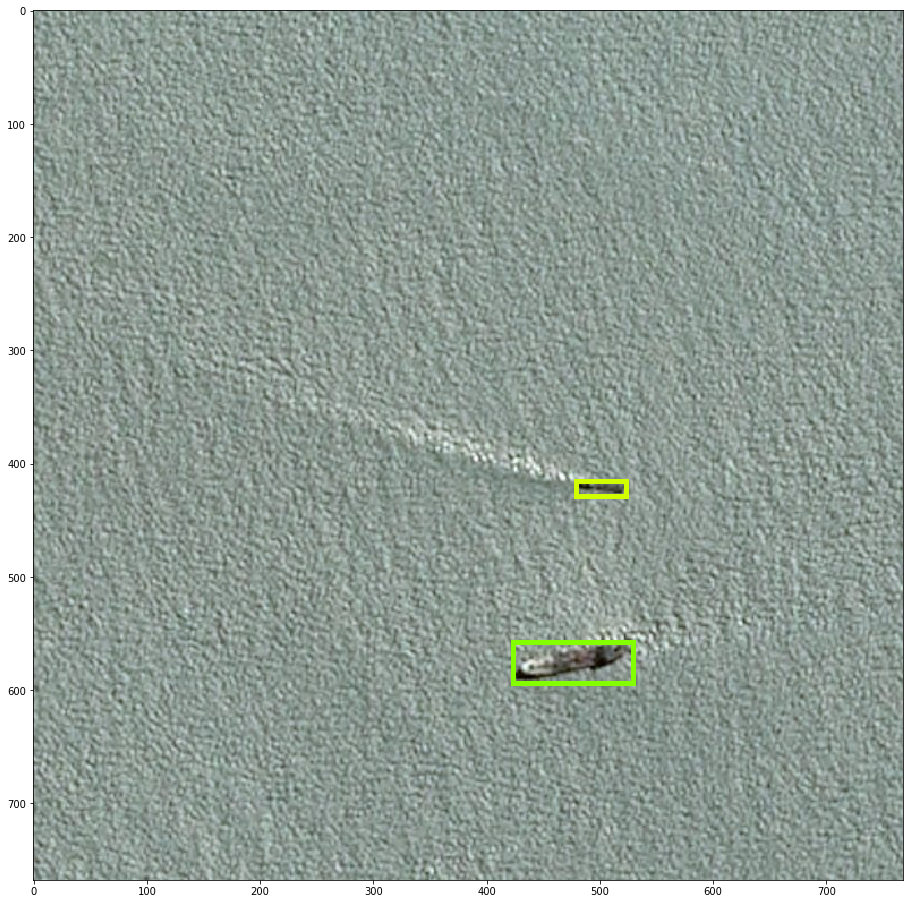

In [4]:
slidingwindow_detect(filename = "kaggle_images/bd14f04b0.jpg", plot = True)

[[180.77896118164062,
  330.62205505371094,
  292.16191482543945,
  537.6036071777344]]

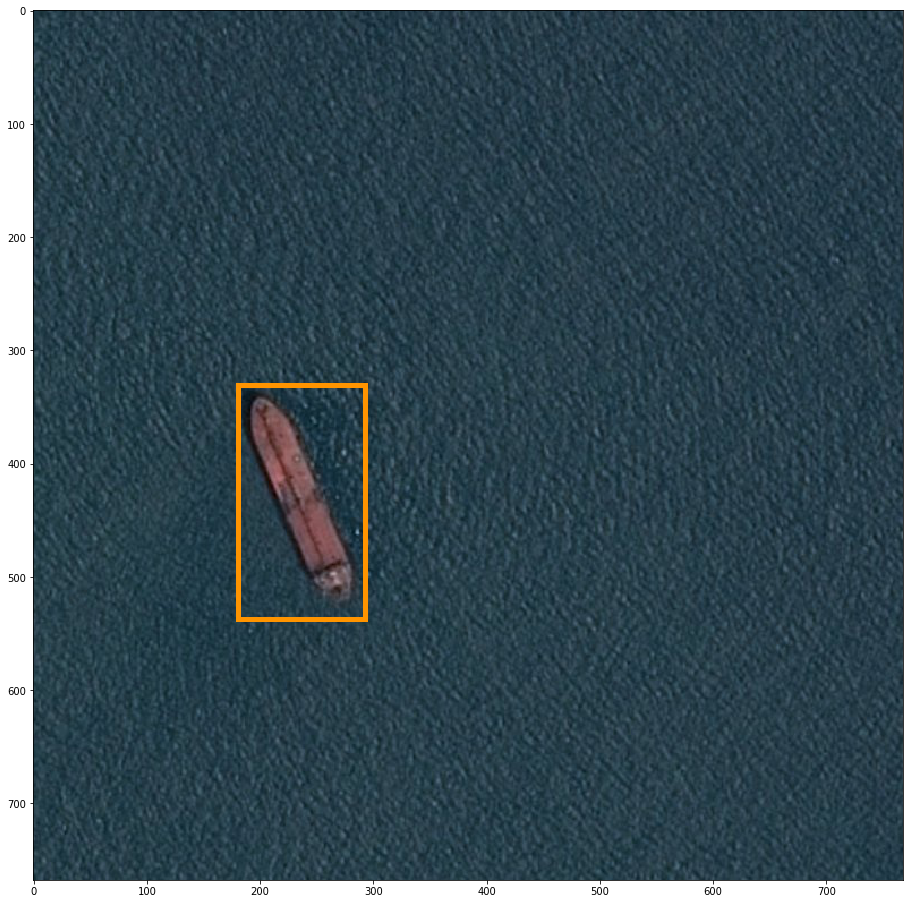

In [5]:
slidingwindow_detect(filename="kaggle_images/7b2b4a85c.jpg", plot=True)

[[235.46653354167938, 17.53158950805664, 453.3037109375, 195.1206512451172]]

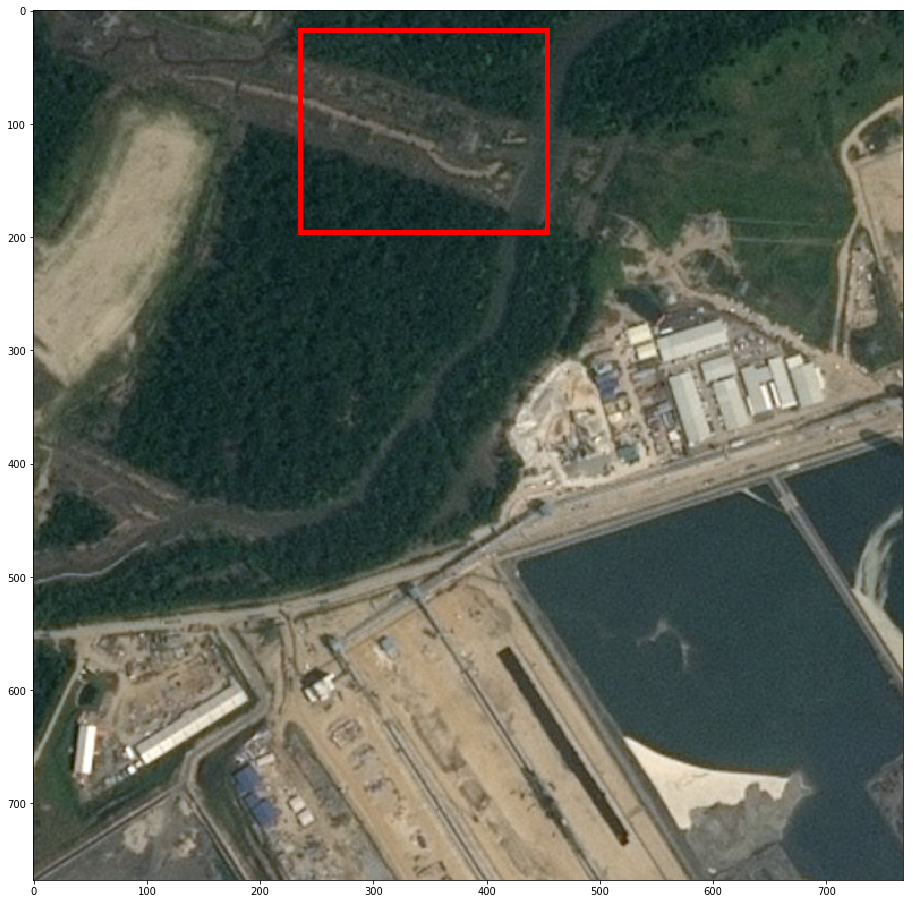

In [6]:
slidingwindow_detect(filename="kaggle_images/5c39d2511.jpg", plot=True)

[[146.5218505859375, 486.4515838623047, 206.9152069091797, 530.9741516113281]]

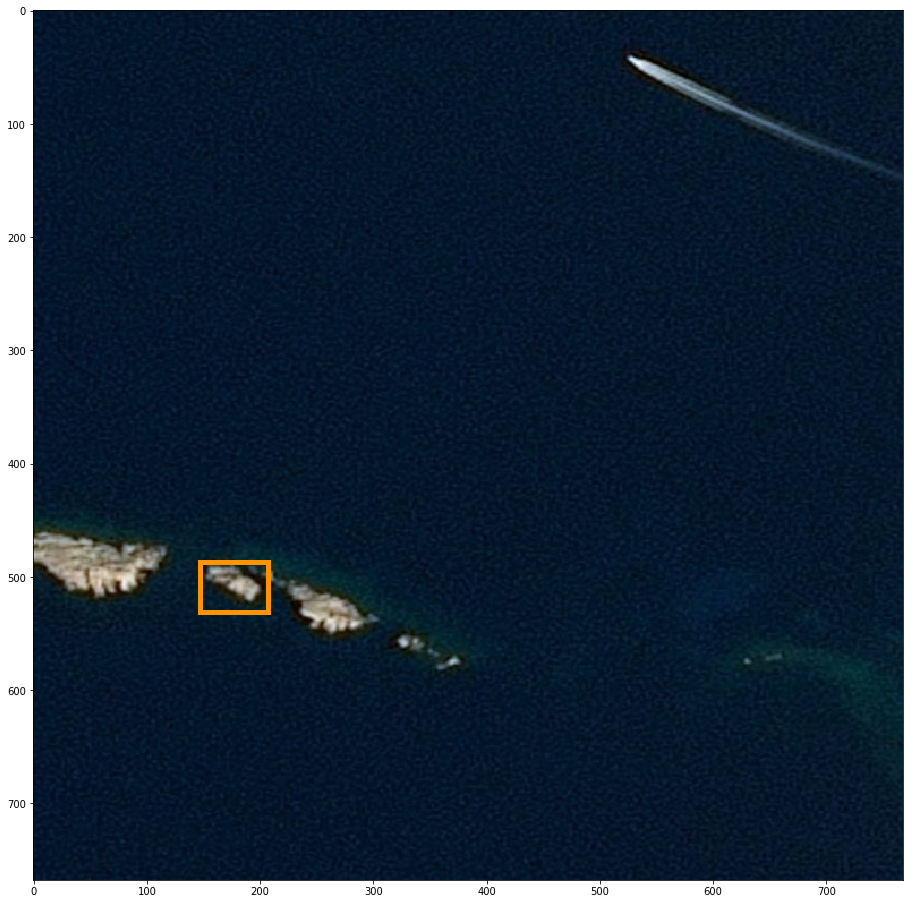

In [7]:
slidingwindow_detect(filename="kaggle_images/8064cfe10.jpg", plot=True)